In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from sklearn.metrics import roc_auc_score, f1_score

# Load data

загружаем данные и убираем лишние пробелы до и после слова

In [2]:
events_df = pd.read_csv("Данные/Происшествия.csv")
events_df.replace('^\s+', '', regex=True, inplace=True) 
events_df.replace('\s+$', '', regex=True, inplace=True)
events_df.rename(columns={'Дата и время  пожара ': 'Местное время'}, inplace=True)

In [3]:
weather_stats_df = pd.read_csv("Данные/Данные по метеостанциям.csv", low_memory=False)
weather_stats_df.replace('^\s+', '', regex=True, inplace=True) 
weather_stats_df.replace('\s+$', '', regex=True, inplace=True)

In [4]:
respective_weather_df = pd.read_csv('Данные/Данные_по_метеостанциям_Соответствие_МО.csv')
respective_weather_df.replace('^\s+', '', regex=True, inplace=True) 
respective_weather_df.replace('\s+$', '', regex=True, inplace=True)

In [5]:
predict_df = pd.read_csv('Данные/ОЯ и НЯ.csv')
predict_df.rename(columns={'Дата, время начала': 'Местное время'}, inplace=True)
predict_df.replace('^\s+', '', regex=True, inplace=True) 
predict_df.replace('\s+$', '', regex=True, inplace=True)

переводим МО в название метеостанции которая отвечает за этот округ

In [6]:
MO_to_weather_station = dict(respective_weather_df.values)
MO_to_weather_station = {x: y.split()[1] for x, y in MO_to_weather_station.items()}

In [7]:
events_df['meteostation'] = events_df['Район'].map(MO_to_weather_station)

переводим время в тайм стампы

In [8]:
weather_stats_df["Местное время"] = pd.to_datetime(weather_stats_df["Местное время"], format="%d.%m.%Y %H:%M")
events_df["Местное время"] = pd.to_datetime(events_df["Местное время"], format="%Y-%m-%d %H:%M:%S")
predict_df["Местное время"] = pd.to_datetime(predict_df["Местное время"], format="%Y-%m-%d %H:%M:%S")

In [9]:
events_df["timestamp"] = pd.to_numeric(events_df["Местное время"])
weather_stats_df["timestamp"] = pd.to_numeric(weather_stats_df["Местное время"])

изменяем дату в events_df на максимально приближенную к дате из weather_df

In [10]:
events_timestamps = list(events_df["timestamp"])
weather_stats_timestamps = list(sorted(set(weather_stats_df["timestamp"])))
new_events_timestamps = events_timestamps
weather_stats_iterator = 0
events_iterator = 0
while events_iterator != len(events_timestamps):
    if weather_stats_iterator == len(weather_stats_timestamps) - 1:
        new_events_timestamps[events_iterator] = weather_stats_timestamps[weather_stats_iterator]
    elif events_timestamps[events_iterator] > weather_stats_timestamps[weather_stats_iterator + 1]:
        weather_stats_iterator += 1
    else:
        new_events_timestamps[events_iterator] = weather_stats_timestamps[weather_stats_iterator]
        events_iterator += 1
events_df["timestamp"] = new_events_timestamps
events_df

,Район,Тип,Местное время,meteostation,timestamp
0,ГО город Березники,Пожар с гибелью 2-х и более человек,2012-12-18 20:39:00,Березники,1357005600000000000
1,Пермский МО,Особо опасные болезни сельскохозяйственных жив...,2013-01-01 00:00:00,Пермь,1357005600000000000
2,Юрлинский МО,Особо опасные болезни сельскохозяйственных жив...,2013-01-01 00:00:00,Кочёво,1357005600000000000
3,Карагайский МО,Особо опасные болезни сельскохозяйственных жив...,2013-01-01 00:00:00,Верещагино,1357005600000000000
4,Добрянский ГО,Пожар с гибелью 2-х и более человек,2013-01-01 07:50:00,Добрянка,1357016400000000000
...,...,...,...,...,...
3649,Пермский ГО,Аварийные ситуации на ЖД транспорте,2022-12-08 11:50:00,Пермь,1670497200000000000
3650,Пермский ГО,Пожары на объектах торговли,2022-12-16 18:01:00,Пермь,1671210000000000000
3651,Пермский МО,"Крупные ДТП (повреждение 10 и более а/м, ДТП с...",2022-12-25 21:00:00,Пермь,1671998400000000000
3652,Пермский ГО,"Аварии на магистральных газо-, нефте-, продукт...",2022-12-28 13:03:00,Пермь,1672225200000000000


In [11]:
events_df["Местное время"] = pd.to_datetime(events_df["timestamp"])
events_df.drop("timestamp", axis=1, inplace=True)

соединяем данные по погоде и события, которые произошли в определенное время 

In [12]:
merged_df = weather_stats_df.merge(events_df, on=['meteostation', 'Местное время'], how='left')

In [13]:
merged_df.merge(predict_df[['Местное время', 'Характеристика']], on='Местное время', how='left')['Характеристика'].isna().sum()

564212

In [14]:
merged_df['Тип'] = merged_df['Тип'].fillna('Нет события')
merged_df['Район'] = merged_df['Район'].fillna('')

убираем события с количеством встреч меньше количества фолдов кросс-валидации

In [15]:
majority_incedents = merged_df['Тип'].value_counts()[merged_df['Тип'].value_counts() > 100].keys().tolist()

In [16]:
merged_df = merged_df[merged_df['Тип'].isin(majority_incedents)]

# Data shifts

In [17]:
merged_df['RRR'] = merged_df['RRR'].map(lambda x: x if x not in ['Осадков нет', 'Следы осадков'] else 0)
merged_df['sss'] = merged_df['sss'].map(lambda x: x if x not in ['Снежный покров не постоянный.'] else 0)

In [18]:
selected_columns = ['T', 'Td', 'P', 'Po', 'Pa', 'U', 'DD', 'Ff', 'ff10', 
                       'ff3', 'N', 'WW', 'W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm',
                   'Ch', 'RRR', 'tR', 'E', 'Tg', "E'"] # 'sss' 'VV'
cat_features = ['DD', 'N', 'W1', 'W2', 'WW', 'Cl', 'Nh', 'H', 'Cm', 'Ch', 'E', "E'"]

In [19]:
merged_df = merged_df[['Местное время', 'Тип', 'Район', 'meteostation', *selected_columns]]

In [20]:
merged_df = merged_df.sort_values(by=['Местное время'])

In [21]:
merged_df['meteostation'].value_counts().keys()

Index(['Гайны', 'Чердынь', 'Оханск', 'Бисер', 'Ножовка', 'Кудымкар',
       'Чернушка', 'Верещагино', 'Пермь', 'Лысьва', 'Октябрьский',
       'Чайковский', 'Кочево', 'Коса', 'Губаха', 'Березники', 'Оса',
       'Добрянка', 'Усть-Черная', 'Чермоз', 'Кунгур', 'Кын', 'Большая Соснова',
       'Вая'],
      dtype='object', name='meteostation')

In [22]:
merged_df[merged_df['meteostation'] == 'Чердынь']['Тип'].value_counts()

Тип
Нет события                                             29141
Аварии на электроэнергетических системах                   30
Аварии на коммунальных системах жизнеобеспечения ХВС        5
Пожар с гибелью 2-х и более человек                         3
Пожары повышенного номера                                   1
Загрязнения окружающей среды                                1
Name: count, dtype: int64

In [23]:
dfs = []
for meteo in set(merged_df['meteostation'].tolist()):
    class_df = merged_df[merged_df['meteostation'] == meteo]
    for column in selected_columns:
        for i in range(10):
            class_df[f"{column}_lag{i}"] = class_df[column].shift(i)
    dfs.append(class_df)

C:\Users\vush6\AppData\Local\Temp\ipykernel_18932\1046978547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_df[f"{column}_lag{i}"] = class_df[column].shift(i)
C:\Users\vush6\AppData\Local\Temp\ipykernel_18932\1046978547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_df[f"{column}_lag{i}"] = class_df[column].shift(i)
C:\Users\vush6\AppData\Local\Temp\ipykernel_18932\1046978547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [24]:
merged_df = pd.concat(dfs, ignore_index=False)

In [25]:
# merged_df = merged_df[~merged_df['T_lag9'].isna()]

# Metric decision

Так как на одно время может произойти два инцидента, то это уже не задача мултиклассификации, а задача мультиклассификации. Также у нас присутствует дисбаланс классов, соотвественно в качестве метрики валидации мы будем использовать F1_score(mode='macro'). Это среднее из f1_score по каждому из возможных классов

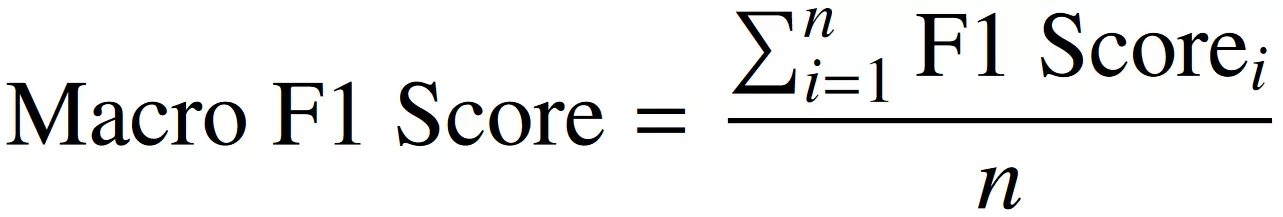

# Model training (CatBoost)

In [26]:
def downsample(df, fraction=1):
        """
        function to downsample majority class.
        """
        # Separate the majority and minority classes
        majority_class = df[df['Тип'] == 'Нет события']
        minority_class = df[df['Тип'] != 'Нет события']  
        
        # Calculate the number of samples needed from the majority class
        num_samples = len(minority_class)
        
        downsampled_majority = majority_class.sample(frac=fraction, replace=True) 
        
        downsampled_df = pd.concat([downsampled_majority, minority_class], axis=0)
        
        return downsampled_df

In [27]:
train_df = merged_df.copy()

In [28]:
train_df = downsample(train_df, fraction=0.001)

In [29]:
train_df['Тип'].value_counts()

Тип
Аварии на электроэнергетических системах                           687
Аварии на коммунальных системах жизнеобеспечения ХВС               657
Нет события                                                        567
Пожар с гибелью 2-х и более человек                                179
Аварии на коммунальных системах жизнеобеспечения Теплоснабжение    178
Загрязнения окружающей среды                                       170
Пожары повышенного номера                                          145
Name: count, dtype: int64

In [30]:
train_df.size

749070

In [31]:
n_splits = 5

target_column = 'Тип'
cat_features = [column for column in train_df.columns if any(map(lambda x: column.startswith(x), cat_features))]
for cat_feature in cat_features:
    train_df[cat_feature] = train_df[cat_feature].fillna('')
    train_df[cat_feature] = train_df[cat_feature].astype('category')
text_features = ['WW']

X = train_df.drop(columns=[target_column, 'Район', 'Местное время', 'meteostation'])
y = train_df[target_column]

In [32]:
clfs = []
scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

for train_index, test_index in kf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf = CatBoostClassifier(
        depth=5,
        iterations=500,
        learning_rate=0.06,
        loss_function="MultiClass", 
        eval_metric="TotalF1:average=Macro", 
        custom_metric="TotalF1:average=Macro",
        boosting_type="Ordered",
        
        # Главная фишка катбуста - работа с категориальными признаками
        cat_features=cat_features,
        # ignored_features = ignored_features,
        
        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=9,
        min_data_in_leaf=243,
        max_bin=187,
        random_strength=1,
        
        # Параметры ускорения
        task_type="CPU",    
        thread_count=-1,
        bootstrap_type="Bernoulli", 
        
        # Важное!
        random_seed=7575,
        # auto_class_weights="SqrtBalanced",
        early_stopping_rounds=50)

    clfs.append(clf)

    clf.fit(
        Pool(X_train, y_train, cat_features=cat_features),
        eval_set=Pool(X_test, y_test, cat_features=cat_features),
        verbose=10,
        use_best_model=True,
        plot=False)

    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average="macro")  # np.mean(np.array(y_pred == y_test))
    scores.append(score)
    print(f"\nfold: f1 score: {score} \n")

assert len(clfs) == n_splits
print(
    "mean f1 score ====>>> " + str(np.mean(scores, dtype="float32")) + " <<<====", np.std(scores).round(4), "\n"
)

0:	learn: 0.1656489	test: 0.1456731	best: 0.1456731 (0)	total: 347ms	remaining: 2m 53s
10:	learn: 0.1865753	test: 0.1814763	best: 0.1848139 (1)	total: 1.72s	remaining: 1m 16s
20:	learn: 0.1874449	test: 0.1798857	best: 0.1879916 (11)	total: 3.02s	remaining: 1m 8s
30:	learn: 0.1919514	test: 0.1857598	best: 0.1880972 (23)	total: 4.33s	remaining: 1m 5s
40:	learn: 0.1934233	test: 0.1884887	best: 0.1888277 (37)	total: 5.51s	remaining: 1m 1s
50:	learn: 0.1992947	test: 0.1915479	best: 0.1915671 (49)	total: 6.79s	remaining: 59.8s
60:	learn: 0.2004897	test: 0.1927168	best: 0.1954274 (56)	total: 8.16s	remaining: 58.8s
70:	learn: 0.2019098	test: 0.1956239	best: 0.1956239 (70)	total: 9.05s	remaining: 54.7s
80:	learn: 0.2050103	test: 0.1997205	best: 0.1997205 (80)	total: 10.5s	remaining: 54.2s
90:	learn: 0.2075717	test: 0.2017233	best: 0.2023148 (85)	total: 11.6s	remaining: 52.2s
100:	learn: 0.2106610	test: 0.2046125	best: 0.2046125 (100)	total: 13.3s	remaining: 52.7s
110:	learn: 0.2121767	test: 0.2

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

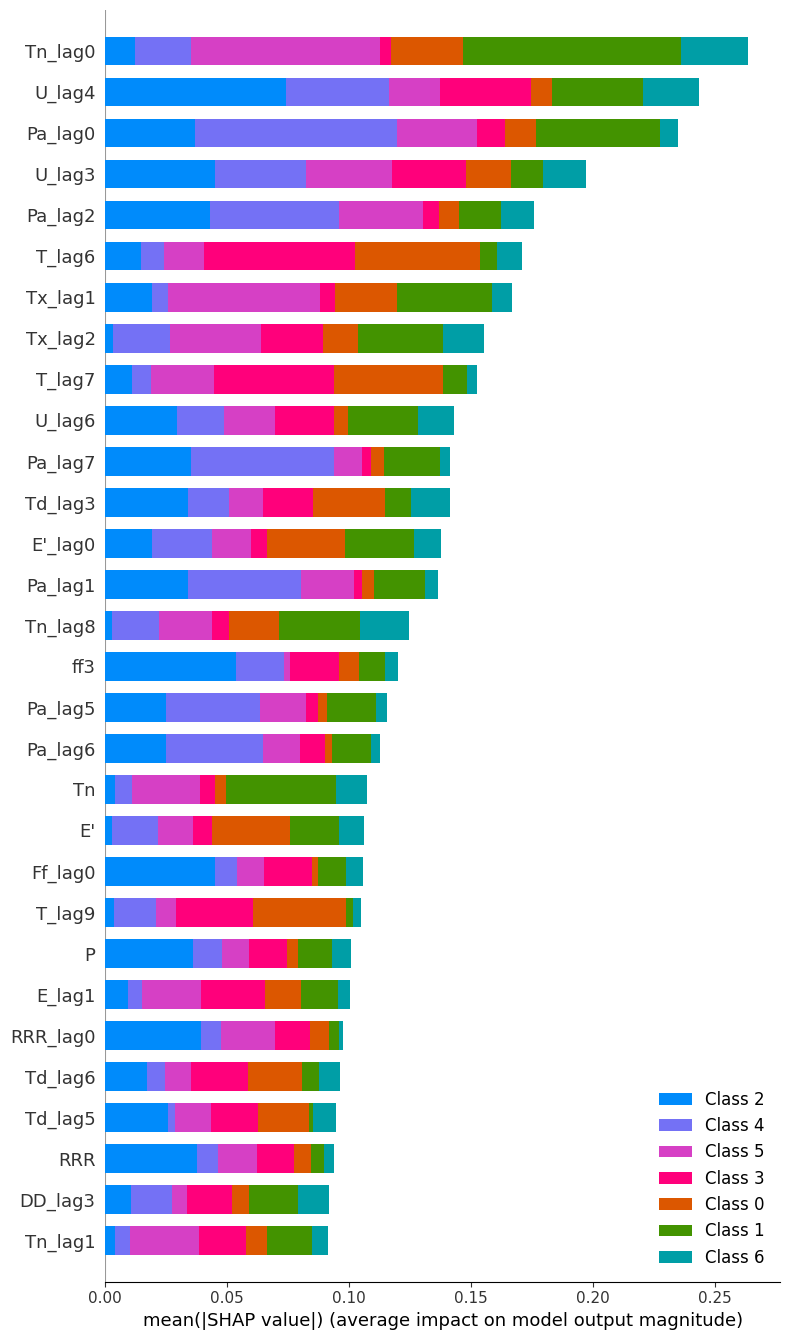

In [34]:
# Посмотрим на SHAP values
import shap

explainer = shap.TreeExplainer(clfs[0])

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=30)

In [35]:
for i, clf in enumerate(clfs):
    clf.save_model(f"models/classificator{i}.cbm",
           format="cbm",
           export_parameters=None,
           pool=None)

# Inference

в общем, я написал код для только одной метиостанции, надеюсь ты сможешь написать цикл

In [100]:
weather_stats_df = pd.read_csv("Данные/Данные по метеостанциям.csv", low_memory=False)
weather_stats_df.replace('^\s+', '', regex=True, inplace=True) 
weather_stats_df.replace('\s+$', '', regex=True, inplace=True)
weather_stats_df["Местное время"] = pd.to_datetime(weather_stats_df["Местное время"], format="%d.%m.%Y %H:%M")

In [101]:
meteostation = 'Чердынь'

In [102]:
meteo_df = weather_stats_df[weather_stats_df['meteostation'] == meteostation]

In [103]:
meteo_df = meteo_df.sort_values(by=['Местное время'])
meteo_df['RRR'] = meteo_df['RRR'].map(lambda x: x if x not in ['Осадков нет', 'Следы осадков'] else 0)

In [104]:
for column in selected_columns:
    for i in range(10):
        meteo_df[f"{column}_lag{i}"] = meteo_df[column].shift(i)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

берем данные за последние 10 дней

In [105]:
meteo_df = meteo_df.iloc[-8 * 10:]

In [106]:
for cat_feature in cat_features:
    meteo_df[cat_feature] = meteo_df[cat_feature].fillna('')
    meteo_df[cat_feature] = meteo_df[cat_feature].astype('category')

X = meteo_df.drop(columns=['Местное время', 'meteostation'])

In [107]:
inf_columns = train_df.drop(columns=[target_column, 'Район', 'Местное время', 'meteostation']).columns.tolist()

In [108]:
X = X[inf_columns]

In [109]:
clfs = [CatBoostClassifier().load_model(f"models/classificator{i}.cbm", format="cbm") for i in range(5)]

матрица прогноов - для каждой строки meteo_df вероятность каждого из классов, ниже в ячейке расшифровка

In [135]:
predict_matrix = np.array([clf.predict_proba(X) for clf in clfs]).mean(axis=0)

In [136]:
clfs[0].classes_

array(['Аварии на коммунальных системах жизнеобеспечения Теплоснабжение',
       'Аварии на коммунальных системах жизнеобеспечения ХВС',
       'Аварии на электроэнергетических системах',
       'Загрязнения окружающей среды', 'Нет события',
       'Пожар с гибелью 2-х и более человек', 'Пожары повышенного номера'],
      dtype=object)